In [ ]:
# default_exp main
from nbdev import *
from utilities.ipynb_docgen import *
import pandas as pd
import matplotlib.pyplot as plt
!date

Sat May 14 13:30:16 PDT 2022


# wtlike interface
> Top-level interface to the rest of the package

In [ ]:
# export
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wtlike.bayesian import get_bb_partition
from wtlike.lightcurve import fit_cells, LightCurve, flux_plot
from wtlike.cell_data import partition_cells
from wtlike.config import *


class WtLike(LightCurve):
    """
    Summary
    ---------
    There are three layers of initialization, implemented in superclasses,
    each with parameters. The classnames, associated parameters and data members set:

    SourceData -- load photons and exposure
        parameters:
          - source : name, a PointSource object, or a Simulation object
          - config [Config()] : basic configuration
          - week_range [None] : range of weeks to load
          - key [''] : the cache key: '' means construct one with the source name, None to disable
          - clear [False] : if using cache, clear the contents first
        sets:
          - photons
          - exposure

    CellData -- create cells
        parameters:
          - time_bins [Config().time_bins] : binning: start, stop, binsize
        sets:
          - cells
        creates copies with new cells:
          - view 
          - phase_view
          
    LightCurve -- likelihood analysis of the cells
        parameters:
          - e_min [10] -- threshold for exposure (cm^2 units)
          - n_min [2]  -- likelihood has trouble with this few
          - lc_key [None] -- possible cache for light curve
        sets:
          - fits, fluxes

    WtLike (this class) -- no parameters (may add BB-specific ones)
        Implements:  bb_view, plot_BB
        sets:
          - bb_flux  (only if bb_view invoked)

    """
    def bb_view(self, p0=0.05, key=None, clear=False):
        """Return a view with the BB analysis applied

        - p0 -- false positive probability parameter

        Its `plot` function will by default show an overplot on the parent's data points.
        """
        #  a new instance
        r = self.view()

        # bb analysis on this to make new  set of cells and poisson fits
        bb_edges  = get_bb_partition(self.config, self.fits,  p0=p0, key=key, clear=clear)
        r.cells = partition_cells(self.config, self.cells, bb_edges)

        r.fits = fit_cells(self.config, r.cells, )
        r.isBB = True
        r.bayes_p0 = p0
        return r
       
    def plot(self, *pars, **kwargs):
        # which view type is this?
        if getattr(self, 'isBB', False):
            return self.plot_bb(*pars, **kwargs)
        elif getattr(self, 'is_phase', False):
            return self.plot_phase(*pars, **kwargs)
        else:
            return super().plot(*pars, **kwargs)

    def plot_bb(self, ax=None, **kwargs):
        """Plot the light curve with BB overplot
        """
        import matplotlib.pyplot as plt
        self.check_plot_kwargs(kwargs)
        figsize = kwargs.pop('figsize', (12,4))
        fignum = kwargs.pop('fignum', 1)
        ts_min = kwargs.pop('ts_min',-1)
        source_name =kwargs.pop('source_name', self.source_name)
        fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)


        colors = kwargs.pop('colors', ('lightblue', 'wheat', 'blue') )
        flux_plot(self.parent.fits, ax=ax, colors=colors, source_name=source_name,
                  label=self.step_name+' bins', **kwargs)
        flux_plot(self.fits, ax=ax, step=True,
                  label=f'BB (p0={100*self.bayes_p0:.0f}%)', zorder=10,**kwargs)
        ax.grid(alpha=0.5)
        fig.set_facecolor('white')
        return fig
    
    def plot_phase(self, ax=None, **kwargs):
        """Plot a phase lightcurve
    
        """
        kw = dict(ylim=(0.975, 1.025), xlim=(0,1) )
        kw.update(kwargs)
        fig, ax = plt.subplots(figsize=(10,5)) if ax is None else (ax.figure, ax)
        fig = super().plot(ax=ax, xlabel=f'phase for {self.period}-day period'); 
        ax.set(**kwargs );
        ax.axhline(1.0, color='grey');
        return fig

### Demonstrate the phase_view with Vela and Geminga

This uses the `phase_view` function to generate a view with cells that are folded according 
to the specified period, relative to UTC 2008.
<details  class="nbdoc-description" >  <summary> Vela setup, 53.05-day period </summary>  <div style="margin-left: 5%;"><pre>SourceData: week_range: None<br>SourceData:  PSR J0835-4510: Restoring from cache with key "PSR J0835-4510_data"<br>SourceData: Source Vela pulsar with:<br>	 data:     3,513,955 photons from 2008-08-04 to 2022-03-21<br>	 exposure: 3,204,316 intervals,  average effective area 3459 cm^2 for 95.7 Ms<br>	 rates:  source 8.56e-06/s, background 2.05e-06/s, TS 7052015.5<br>CellData.rebin: Bin photon data into 711 1-week bins from 54683.0 to 59660.0<br>LightCurve: select 703 cells for fitting with e&gt;35 & n&gt;2<br>CellData.phase_view: Create phase view, 25 bins with period 53.05 days.<br>CellData.rebin: Bin photon data into 2344 2.1-day bins from 54684.6 to 59658.5<br>LightCurve: select 25 cells for fitting with e&gt;10.61 & n&gt;2<br></pre></div> </details>    
<details  class="nbdoc-description" >  <summary> Geminga setup: 365.25-day period </summary>  <div style="margin-left: 5%;"><pre>SourceData: week_range: None<br>SourceData:  PSR J0633+1746: Restoring from cache with key "PSR J0633+1746_data"<br>SourceData: Source Geminga with:<br>	 data:     1,174,267 photons from 2008-08-04 to 2022-03-21<br>	 exposure: 3,292,338 intervals,  average effective area 2700 cm^2 for 98.4 Ms<br>	 rates:  source 3.31e-06/s, background 1.11e-06/s, TS 2276709.9<br>CellData.rebin: Bin photon data into 711 1-week bins from 54683.0 to 59660.0<br>LightCurve: select 693 cells for fitting with e&gt;35 & n&gt;2<br>CellData.phase_view: Create phase view, 50 bins with period 365.25 days.<br>CellData.rebin: Bin photon data into 681 7.3-day bins from 54685.2 to 59659.9<br>LightCurve: select 50 cells for fitting with e&gt;36.525 & n&gt;2<br></pre></div> </details>
<figure style="margin-left: 5%" title="Figure 1">   <img src="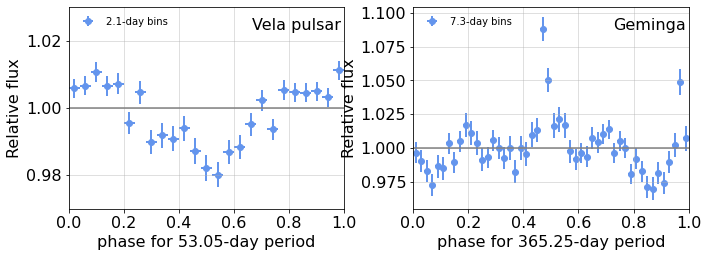
" alt="Figure 1"  <br> </figure>


In [ ]:
#collapse_input
@ipynb_doc
def phase_demo():
    """
    ### Demonstrate the phase_view with Vela and Geminga
    
    This uses the `phase_view` function to generate a view with cells that are folded according 
    to the specified period, relative to UTC {ref_date}.
    {out1}    
    {out2}
    {thefig}
    """
    plt.rc('font', size=16)
    year = 365.25; ref_date='2008'; precess=53.05

    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5)) # sharey=True)
    plt.subplots_adjust(wspace=0.25)
    thefig = figure(fig, width=800)
    
    with capture(f'Vela setup, {precess}-day period') as out1:
        vela = WtLike('Vela pulsar')
        pv = vela.phase_view( period=precess, nbins=25); 
    pv.plot(ax=ax1, xlim=(0,1), ylim=(0.97,1.03))

    with capture(f'Geminga setup: {year}-day period') as out2:
        geminga = WtLike('Geminga')
        gv = geminga.phase_view(year, nbins=50, reference=ref_date)
    gv.plot(ax=ax2, xlim=(0,1))    

    return locals()

if Config().valid:
    phase_demo()

In [ ]:
show_doc(WtLike)
show_doc(WtLike.bb_view)
show_doc(WtLike.phase_view)

<h2 id="WtLike" class="doc_header"><code>class</code> <code>WtLike</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>WtLike</code>(**\*`pars`**, **\*\*`kwargs`**) :: [`LightCurve`](/wtlikelightcurve.html#LightCurve)

Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells
    creates copies with new cells:
      - view 
      - phase_view
      
LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -- likelihood has trouble with this few
      - lc_key [None] -- possible cache for light curve
    sets:
      - fits, fluxes

WtLike (this class) -- no parameters (may add BB-specific ones)
    Implements:  bb_view, plot_BB
    sets:
      - bb_flux  (only if bb_view invoked)

<h4 id="WtLike.bb_view" class="doc_header"><code>WtLike.bb_view</code><a href="__main__.py#L52" class="source_link" style="float:right">[source]</a></h4>

> <code>WtLike.bb_view</code>(**`p0`**=*`0.05`*, **`key`**=*`None`*, **`clear`**=*`False`*)

Return a view with the BB analysis applied

- p0 -- false positive probability parameter

Its `plot` function will by default show an overplot on the parent's data points.

<h4 id="CellData.phase_view" class="doc_header"><code>CellData.phase_view</code><a href="https://github.com/tburnett/wtlike/tree/master/wtlike/cell_data.py#L324" class="source_link" style="float:right">[source]</a></h4>

> <code>CellData.phase_view</code>(**`period`**, **`nbins`**=*`25`*, **`reference`**=*`'2008'`*)

Return a "phase" view, in which the cell time binning is according to phase.

* period -- 'year' | 'precession' | float
* reference -- a UTC date for aligning the bins.

In [ ]:
#collapse_input
full = None
# code for the demo--this shouid be collapsed
@ipynb_doc
def wtlike_demo(clear=False):
    """
    ## Test/Demonstration with 3C 279
    
    > Note that this also demonstrates using the `ipynb_doc` decorator to have a single Jupyterlab cell generate a document
    
    {out1}
    First, the weekly light curve:
    {fig1}
    
    Replot the figure with an expanded scale to see position of a flare:
    {fig2}
    {out3}    {fig3}
    {out4}    {fig4}
    
    Table of BB fits
    {bb_table}
    
    This can be compared with Figure 4 from the [Kerr paper](https://arxiv.org/pdf/1910.00140.pdf)
    {kerr_fig4}
    """
    global full
    

    with capture('Setup 3C 279') as out1:
        full = WtLike('3C 279', clear=clear)
    
    fig1 = figure(
        full.plot(yscale='log', ylim=(0.2,20), figsize=(15,5), xlabel='MJD', fmt='.', fignum=1),
        caption='Full scale', width=600)  
    
    fig2 = figure(
        full.plot(  figsize=(15,5), xlabel='MJD', fmt='o', fignum=2,  xlim=(57100, 57300),),
        width=600)  
    
    with capture_hide('Define orbit-based subset around large flare at MJD 57189') as out3:
        orbit = full.view((57186, 57191, 0))
    fig3 = figure(
        orbit.plot(fmt='o', tzero=57186,   fignum=3 ),
            width=600)
    
    with capture_hide('Apply BB and overplot it with the cells on which it is based') as out4:
        bborbit = orbit.bb_view()
    fig4 = figure(
        bborbit.plot(fmt='o', tzero=57186,   fignum=4),
                width=600)
    
    bb_table = orbit.fluxes
    
    kerr_fig4 = image('kerr_fig4.png', width=600, caption=None)
    return locals()

if Config().valid:
    wtlike_demo( False)

Docstring formatting failed: 'NBimage' object has no attribute 'get_size_inches'

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10-time_series.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Sat May 14 13:30:24 PDT 2022
